This work uses the CIFAR-10 data set, reference:

Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

Link: https://www.cs.toronto.edu/~kriz/cifar.html

Imports

In [1]:
import torch
import pickle
import tarfile
import numpy as np
from torch import nn
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Notebook control

In [2]:
extract_files = False
visualise_images = True

BATCH_SIZE = 64
EPOCHS = 5

Extraction

In [3]:
if extract_files:
    archive_path = "cifar-10-python.tar.gz"
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall()

Loading data

In [4]:
def load_batch(file_path):
    with open(file_path, "rb") as file:
        batch = pickle.load(file, encoding="bytes")
    data = batch[b"data"]
    labels = batch[b"labels"]
    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return(data, np.array(labels))

#Training
x_train = []
y_train = []

for i in range(1, 6):
    data, labels = load_batch(
        f"cifar-10-batches-py/data_batch_{i}"
    )
    x_train.append(data)
    y_train.append(labels)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

#Testing
x_test, y_test = load_batch(
    "cifar-10-batches-py/test_batch"
)

#Normalizing
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

Visualise 

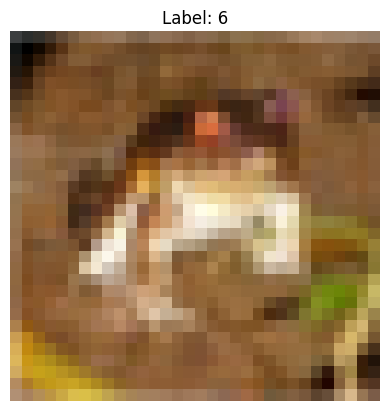

In [5]:
if visualise_images:
    plt.imshow(x_train[0])
    plt.title(f"Label: {y_train[0]}")
    plt.axis("off")

CNN

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation="softmax"),
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/5


2025-12-28 16:56:45.368171: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2025-12-28 16:57:38.730980: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


782/782 - 56s - 72ms/step - accuracy: 0.2609 - loss: 1.9886 - val_accuracy: 0.3345 - val_loss: 1.8265
Epoch 2/5
782/782 - 53s - 68ms/step - accuracy: 0.3432 - loss: 1.7764 - val_accuracy: 0.3727 - val_loss: 1.7177
Epoch 3/5
782/782 - 53s - 68ms/step - accuracy: 0.3742 - loss: 1.6998 - val_accuracy: 0.3914 - val_loss: 1.6565
Epoch 4/5
782/782 - 51s - 65ms/step - accuracy: 0.3955 - loss: 1.6508 - val_accuracy: 0.4123 - val_loss: 1.6272
Epoch 5/5
782/782 - 51s - 65ms/step - accuracy: 0.4149 - loss: 1.6079 - val_accuracy: 0.4269 - val_loss: 1.5781


Loss/Accuracy Curves

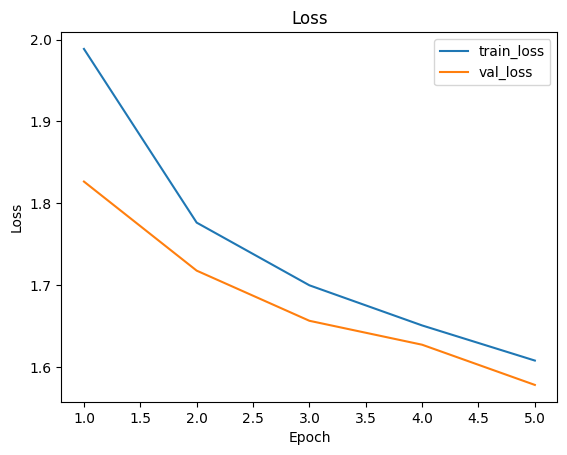

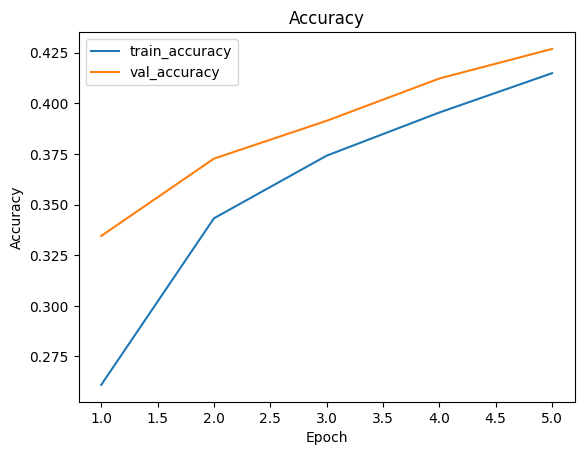

In [7]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = np.arange(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(epochs, train_acc, label="train_accuracy")
plt.plot(epochs, val_acc, label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

Confusion Matrix

2025-12-28 17:01:12.790781: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


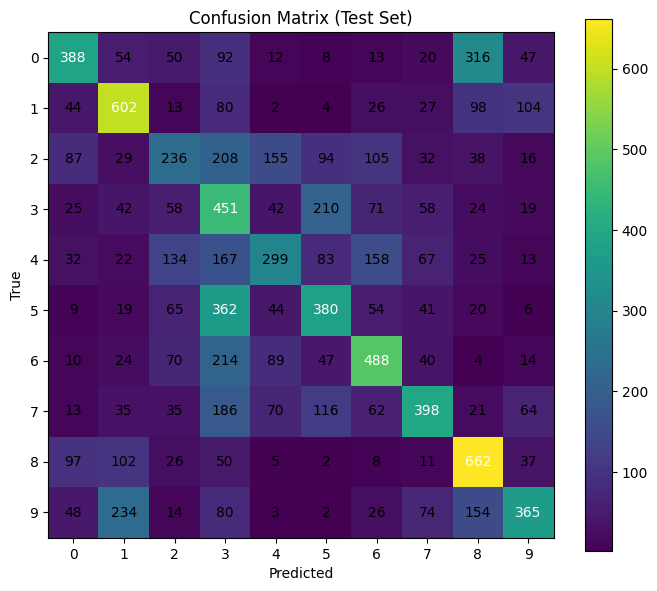

In [8]:
y_pred_probs = model.predict(x_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

confusion = tf.math.confusion_matrix(
    y_test,
    y_pred,
    num_classes=10,
).numpy()

plt.figure(figsize=(7, 6))
plt.imshow(confusion, interpolation="nearest")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

threshold = confusion.max() / 2.0
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(
            j,
            i,
            str(confusion[i, j]),
            ha="center",
            va="center",
            color="white" if confusion[i, j] > threshold else "black",
        )

plt.tight_layout()
plt.show()